In [1]:
%matplotlib inline



# Compute Power Spectral Density of inverse solution from single epochs

Compute PSD of dSPM inverse solution on single trial epochs restricted
to a brain label. The PSD is computed using a multi-taper method with
Discrete Prolate Spheroidal Sequence (DPSS) windows.


In [2]:
# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#
# License: BSD-3-Clause

In [9]:
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd_epochs

print(__doc__)

data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
fname_inv = meg_path / 'sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = meg_path / 'sample_audvis_raw.fif'
fname_event = meg_path / 'sample_audvis_raw-eve.fif'
label_name = 'Aud-lh'
fname_label = meg_path / 'labels' / f'{label_name}.label'
subjects_dir = data_path / 'subjects'

event_id, tmin, tmax = 1, -0.2, 0.5
snr = 1.0  # use smaller SNR for raw data
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# Load data
inverse_operator = read_inverse_operator(fname_inv)
label = mne.read_label(fname_label)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Set up pick list
include = []
raw.info['bads'] += ['EEG 053']  # bads + 1 more

# pick MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       include=include, exclude='bads')
# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=dict(mag=4e-12, grad=4000e-13,
                                                    eog=150e-6))

# define frequencies of interest
fmin, fmax = 0., 70.
bandwidth = 4.  # bandwidth of the windows in Hz



Automatically created module for IPython interactive environment
Reading inverse operator decomposition from /home/nahuel/Documents/TESIS/DATA/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    D

Channels,"305 MEG, 0 EEG"
Source space,surface with 7498 sources
Source orientation,Loose (0.20000000298023224)


In [13]:
label

<Label | unknown, 'Aud-lh', lh : 1097 vertices>

## Compute source space PSD in label

..note:: By using "return_generator=True" stcs will be a generator object
         instead of a list. This allows us so to iterate without having to
         keep everything in memory.



In [6]:
n_epochs_use = 10
stcs = compute_source_psd_epochs(epochs[:n_epochs_use], inverse_operator,
                                 lambda2=lambda2,
                                 method=method, fmin=fmin, fmax=fmax,
                                 bandwidth=bandwidth, label=label,
                                 return_generator=True, verbose=True)

# compute average PSD over the first 10 epochs
psd_avg = 0.
for i, stc in enumerate(stcs):
    psd_avg += stc.data
psd_avg /= n_epochs_use
freqs = stc.times  # the frequencies are stored here
stc.data = psd_avg  # overwrite the last epoch's data with the average

Considering frequencies 0 ... 70 Hz
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 99 -> 99
Using 2 tapers with bandwidth 4.0 Hz on at most 10 epochs


Visualize the 10 Hz PSD:



In [7]:
brain = stc.plot(initial_time=10., hemi='lh', views='lat',
                 clim=dict(kind='value', lims=(20, 40, 60)),
                 smoothing_steps=3, subjects_dir=subjects_dir)
brain.add_label(label, borders=True, color='k')

RuntimeError: Could not load any valid 3D backend
pyvistaqt: No module named 'pyvista'
notebook: No module named 'ipyevents'

 install pyvistaqt, using pip or conda:
'pip install pyvistaqt'
'conda install -c conda-forge pyvistaqt'

 or install ipywidgets, if using a notebook backend
'pip install ipywidgets'
'conda install -c conda-forge ipywidgets'

Visualize the entire spectrum:



Text(0, 0.5, 'Power Spectral Density')

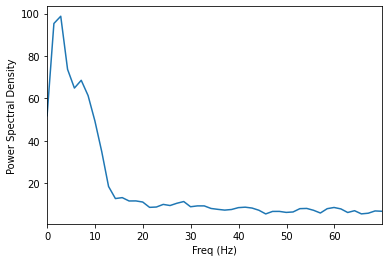

In [8]:
fig, ax = plt.subplots()
ax.plot(freqs, psd_avg.mean(axis=0))
ax.set_xlabel('Freq (Hz)')
ax.set_xlim(stc.times[[0, -1]])
ax.set_ylabel('Power Spectral Density')